In [1]:
import numpy as np
import pandas as pd
import multiprocessing

from scipy import integrate
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

from sklearn.linear_model import LinearRegression


import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline

%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 800)

Loading BokehJS ...

In [ ]:
# Normal density plot
plt.rcParams["figure.figsize"] = [10, 5]

mu = 1000
# variance = 1
sigma = 100 # math.sqrt(variance)
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), linewidth = 4)

## Optimization functions

In [2]:
# Loss function --- demand, buy, margin, cost
def L(d, b, margin, cost):
    if d > b:
        return (d - b)*margin
    elif d < b:
        return (b - d)*cost
    elif d == b:
        return 0
    else:
        print('Error')

# Expected value of Loss function given a buy, article, prediction distribution
def EL(b_0, mu_0, sigma_0, margin_0, cost_0):
    I = lambda x: L(x, b_0, margin_0, cost_0) * stats.norm.pdf(x, mu_0, sigma_0) # I for integrand
    Exp_loss = integrate.quad(I, mu_0 - 4*sigma_0, mu_0 + 4*sigma_0)
    return round(Exp_loss[0], 2) 


# return buy qty that minimizes expected loss
def min_expected_loss(mu, sigma, margin, cost):
    
    buys = list(range(mu - 1*sigma, mu + 1*sigma, 50)) # buy qtys for which calculate E[L]
    
    ELs = [EL(b, mu, sigma, margin, cost) for b in buys] # E[L|b] for b in buys  
    
    min_loss_index = ELs.index(min(ELs)) # index of buy qty that minimizes E[L]
    
    return buys[min_loss_index]          # buy qty that minimized E[l]

### Stan Smith: Normal prediction distribution

In [ ]:
# Stan Smith Prediction Distribution 

plt.rcParams["figure.figsize"] = [6, 3]

mu = 38000
sigma = 5000 # math.sqrt(variance)
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), linewidth = 4)

plt.title('Stan Smith Prediction Distribution', size = 18)
plt.xlabel('Net Demand Quantity', size = 18)
plt.ylabel('Probability Density', size = 18)

Buying 48900 units minimizes expected loss

Minimized expected loss: 58326.11

Expected loss with 20% buffer approach: 66453.42

Profit increase: -8127.309999999998


Text(0.5, 1.0, 'Expected Loss vs. Buy Quantity')

Text(0.5, 0, 'Buy Quantity')

Text(0, 0.5, 'Expected Loss')

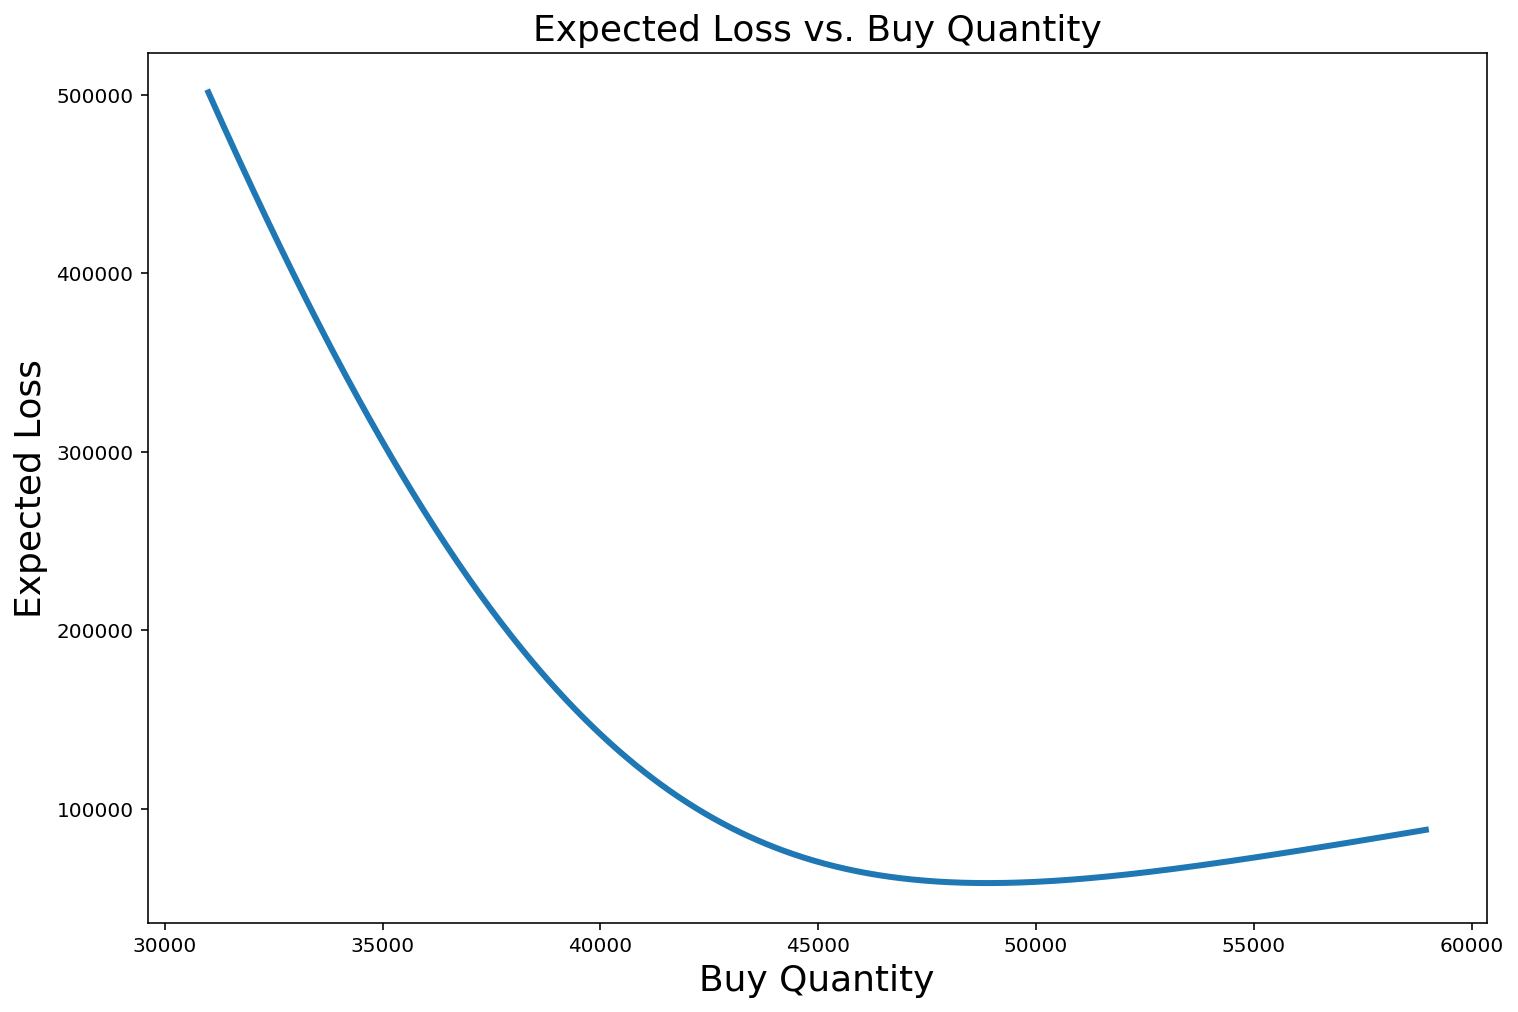

In [7]:
# Stan Smith: Prediction, E[L] minimizing buy, comparison 

# Plot hypothetical Expected loss, function of buy qty
mu = 38000
sigma = 7000
margin = 65.80
cost = 4.20

buys = list(range(mu - 1*sigma, mu + 3*sigma, 50)) # buy qtys for which calculate E[L]
ELs = [EL(b, mu, sigma, margin, cost) for b in buys]

print('Buying', buys[ELs.index(min(ELs))], 'units minimizes expected loss') # buy qty that minimizes expected loss
print()
print('Minimized expected loss:', min(ELs)) # minimized Expected loss
print()
print('Expected loss with 20% buffer approach:', EL(38000*1.2, 38000, 7000, 65.80, 4.2))
print()
print('Expected profit increase:', EL(buys[ELs.index(min(ELs))], 38000, 7000, 65.80, 4.20) - EL(38000*1.2, 38000, 7000, 65.80, 4.2))

# L(38000, buys[ELs.index(min(ELs))], 65.80, 4.20) # loss assoc. with that buy if prediction perfect

plt.rcParams["figure.figsize"] = [12,8]
plt.plot(buys, ELs, linewidth = 3)

plt.title('Expected Loss vs. Buy Quantity', size = 18)
plt.xlabel('Buy Quantity', size = 18)
plt.ylabel('Expected Loss', size = 18)

### Comparing Distributions

In [ ]:
X = np.random.normal(loc=0.0, scale=1.0, size=1000) # NORMAL
plt.hist(X, density = True)

x = np.linspace(-4, 4, 100)
plt.plot(x, stats.norm.pdf(x, 0, 1), linewidth = 4)

In [ ]:
# Kolmogorov-Smirnov test
stats.kstest(X, 'norm')

In [ ]:
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

qqplot(X, line='s')

### Stan Smith -- asymmetric prediction distribution

In [ ]:
# c = np.random.gamma(shape = 2, scale = 200, size = 1000) + 600 # GAMMA
# plt.hist(c, density = True, bins = 50)

shape = 5
scale = 2000
shift = 38000 - shape*scale

x = np.linspace(0, shape*scale + 5*math.sqrt(shape*scale**2), 100) + shift
plt.plot(x, stats.gamma.pdf(x - shift, a = shape, scale = scale), linewidth = 4)

plt.title('Skewed Distribution (shifted Gamma(shape = 5, scale = 2000))', size = 18)
plt.xlabel('Net Demand Quantity', size = 18)
plt.ylabel('Density', size = 18)

In [9]:
# ------ GAMMA EXPECTED LOSS -------
# We think demand will be Gamma(shape, scale), with mean shape*scale, variance shape*scale^2
# For article with cost = cost_0, margin = margin_0
 
import math

# Expected value of Loss function, given: buy, shape, scale, margin, cost, non-centrality
def EL_gamma(b_0, shape_0, scale_0, margin_0, cost_0, shift_0):
    
    I = lambda x: L(x, b_0, margin_0, cost_0) * stats.gamma.pdf(x - shift_0, a = shape_0, scale = scale_0) # I for integrand
    
    Exp_loss = integrate.quad(I, 0 + shift_0, shift_0 + shape_0*scale_0 + 5*math.sqrt(shape_0*scale_0**2))
    
    return round(Exp_loss[0], 2) 


buying 45700 units minimizes expected loss

The minimized expected loss is: 44883.26

Expected loss with 20% buffer approach: 44889.12

Expected profit increase: -5.860000000000582


Text(0.5, 1.0, 'Expected Loss vs. Buy Quantity')

Text(0.5, 0, 'Buy Quantity')

Text(0, 0.5, 'Expected Loss')

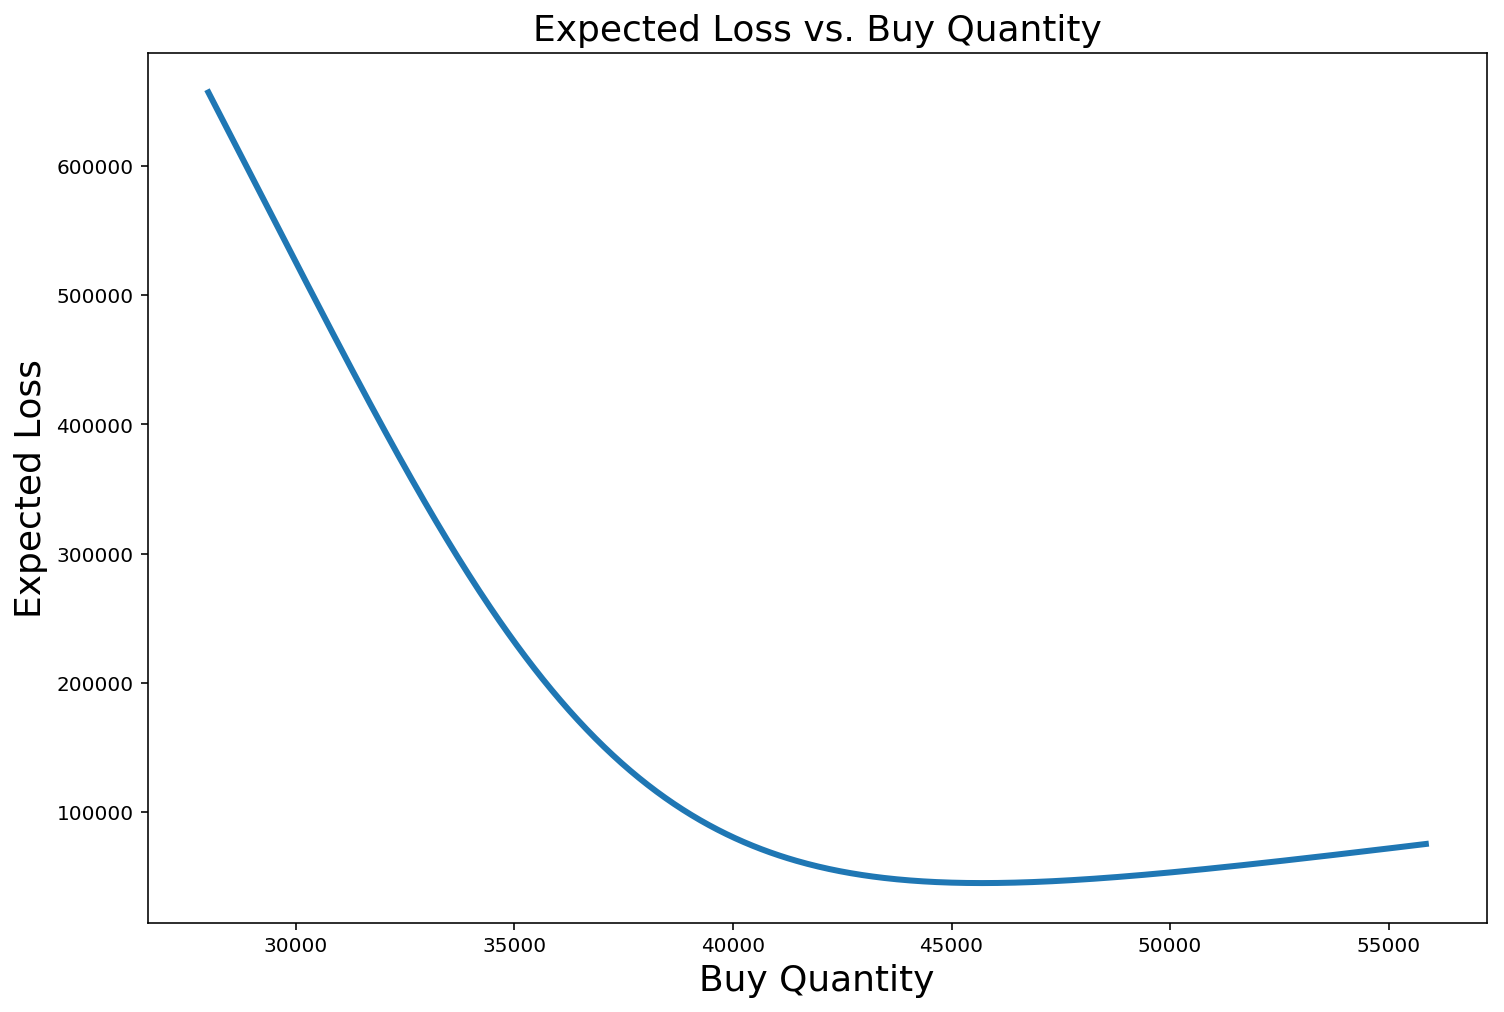

In [10]:
# Plot hypothetical Expected loss, function of buy qty
shape = 5
scale = 2000
shift = 38000 - shape*scale

margin = 65.80
cost = 4.20

buys = list(range(0 + shift, shift + shape*scale + 4*np.int(math.sqrt(shape*scale**2)), 50)) # buy qtys to for which it calculates E[L]
ELs = [EL_gamma(b, shape, scale, margin, cost, shift) for b in buys]


print('buying', buys[ELs.index(min(ELs))], 'units minimizes expected loss')
print()
print('The minimized expected loss is:', min(ELs)) # minimized Expected loss
print()
print('Expected loss with 20% buffer approach:', EL_gamma(38000*1.2, shape, scale, margin, cost, shift))
print()
print('Expected profit increase:', EL_gamma(buys[ELs.index(min(ELs))], shape, scale, margin, cost, shift) - EL_gamma(38000*1.2, shape, scale, margin, cost, shift))

# print('Loss of', L(38000, buys[ELs.index(min(ELs))], 65.80, 4.20), 'if we buy optimally and predict perfectly') # loss assoc. with that buy if prediction perfect

plt.rcParams["figure.figsize"] = [12,8]
plt.plot(buys, ELs, linewidth = 3)

plt.title('Expected Loss vs. Buy Quantity', size = 18)
plt.xlabel('Buy Quantity', size = 18)
plt.ylabel('Expected Loss', size = 18)



### Combine information

In [ ]:
x = np.random.normal(loc=1000, scale=100, size=1000) # NORMAL
c = np.random.gamma(shape = 2, scale = 200, size = 1000) + 600 # GAMMA

plt.hist((x, c), bins = 20, density = True)
plt.title('Combining Information', size = 18)
plt.xlabel('Hypothetical Buy Quantity Data Points', size = 18)

In [ ]:
xc = np.concatenate((x, c)) # NORMAL + GAMMA
pd.DataFrame(xc).quantile((0.05, 0.95))
plt.hist(xc, bins = 40, density = True, color = 'skyblue')
plt.axvline(700, linestyle='dashed', linewidth=3)
plt.axvline(1324, linestyle='dashed', linewidth=3)
plt.axvline(xc.mean(), color = 'orange', linestyle='dashed', linewidth=3)

plt.title('Combining Information: Empirical Mean and Confidence Intervals', size = 18)
plt.xlabel('Hypothetical Buy Quantity Data Points', size = 18)

## Standard deviation estimation

In [ ]:
dat = pd.read_csv('weekly_sales_all.csv', low_memory=False, index_col = 0) # *** DATA ***


In [ ]:
dat.head()
dat.shape

In [ ]:
dat2 = pd.DataFrame(dat.groupby(['article_number', 'season'])['net_qty'].sum())

In [ ]:
dat3 = dat2.groupby('article_number').aggregate(['mean', 'std', 'max', 'count'])

In [ ]:
dat3.head()
dat3.dropna(inplace=True)

dat3 = dat3[dat3['net_qty']['max'] < 50000]

dat3.head()

In [ ]:
X = np.array(dat3['net_qty']['max']).reshape(-1, 1)
y = np.array(dat3['net_qty']['std'])

In [ ]:
reg = LinearRegression().fit(X, y)

In [ ]:
reg.score(X, y)
reg.coef_

reg.intercept_ 
reg.predict([[38000]])

reg.coef_*38000 + reg.intercept_

### Plot SD against mean

In [ ]:
dat_max = dat3['net_qty']['max']
dat_std = dat3['net_qty']['std']

dat_max.head()

In [ ]:
plt.rcParams["figure.figsize"] = [12,9]
plt.scatter(dat3['net_qty']['max'], dat3['net_qty']['std'])

plt.title('Standard Deviation vs. Max Season Net Demand Qty', size = 18)
plt.xlabel('Max Season Net Demand Qty', size = 18)
plt.ylabel('Standard Deviation', size = 18)

### Optimal buy for SDs

In [ ]:
sigs = np.linspace(100, 700, 100)
opt_buys = [min_expected_loss(1000, np.int(s), 85, 15) for s in sigs]

In [ ]:
plt.plot(sigs, opt_buys, linewidth = 3)

plt.title('Optimal Buy vs. Prediction Standard Dev.', size = 18)
plt.xlabel('Standard Deviation', size = 18)
plt.ylabel('Optimal Buy', size = 18)

plt.rcParams["figure.figsize"] = [18, 9]


## New Article EDA

In [50]:
dat = pd.read_csv('weekly_sales_all.csv', low_memory=False, index_col = 0) # *** DATA ***


/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [106]:
dat2 = pd.DataFrame(dat.groupby(['article_number', 'year', 'season'])['net_sales'].sum())

In [52]:
dat2.reset_index(inplace=True)

In [53]:
dat_ref = pd.read_csv('dat_ref.csv')
dat_ref = dat_ref[['group_article', 'rmh_product_division_descr', 'rmh_category_descr', 'rmh_retail_section_descr', 'rmh_product_type_descr']]

In [55]:
dat3 = pd.merge(dat2, dat_ref, left_on='article_number', right_on='group_article')

In [56]:
len(set(dat2.article_number).intersection(set(dat_ref.group_article)))

dat2.shape
dat3.shape

len(dat3.article_number.unique())

64950

(223870, 4)

(577732, 9)

64950

In [107]:
# Retrieve some SS19 only articles, to then build empirical-integrated priors for
dat2

net_sales
article_number year season           
001354         2015 FW15     20804.39
                    SS16      4937.38
               2016 FW16     36465.54
                    SS16     25322.39
                    SS17      8135.41
               2017 FW17     70245.79
                    SS17     22632.90
                    SS18     13229.36
               2018 FW18     98018.76
                    SS18     60440.82
                    SS19     14980.83
               2019 SS19     34815.77
002214         2015 FW15     20921.47
                    SS16      7324.06
               2016 FW16     79187.52
                    SS16     43116.85
                    SS17     17561.97
               2017 FW17    151741.79
                    SS17     75582.51
                    SS18     26798.45
               2018 FW18    212977.18
                    SS18    123108.59
                    SS19     38898.50
               2019 SS19     85697.22
002232         2015 FW15     64275.51
                    SS16     25751.55
               2016 FW16    210339.79
                    SS16    227688.83
                    SS17     36443.98
               2017 FW17    278228.38
                    SS17    185287.67
                    SS18     42865.75
               2018 FW18    363884.40
                    SS18    244996.58
                    SS19     47159.80
               2019 SS19    197295.81
002240         2015 FW15     24094.63
                    SS16      7045.63
               2016 FW16     49798.57
                    SS16     25975.07
                    SS17     12322.14
               2017 FW17     30849.40
                    SS17     24010.81
                    SS18      9980.03
               2018 FW18     48313.25
                    SS18     24781.79
                    SS19      9954.40
               2019 SS19     32233.50
002267         2015 FW15     25932.50
                    SS16      9467.24
               2016 FW16     76580.08
                    SS16     42120.44
                    SS17     13294.18
               2017 FW17    149666.04
                    SS17     63047.15
                    SS18     27676.06
               2018 FW18    177269.68
                    SS18     93468.59
                    SS19     38765.98
               2019 SS19     86606.17
002431         2015 FW15     16927.94
                    SS16      7973.29
               2016 FW16     39311.70
                    SS16     29220.90
                    SS17      7285.29
               2017 FW17     24997.79
                    SS17     29337.88
                    SS18      7933.73
               2018 FW18     34762.16
                    SS18     27160.64
                    SS19      7848.81
               2019 SS19     27855.61
002759         2015 FW15     15455.91
                    SS16      4878.57
               2016 FW16     30945.10
                    SS16     34196.46
                    SS17      4737.73
               2017 FW17     49941.57
                    SS17     28476.96
                    SS18     12349.34
               2018 FW18     73358.35
                    SS18     60067.26
                    SS19     11182.48
               2019 SS19     42365.72
002760         2015 FW15     13646.61
                    SS16      4638.20
               2016 FW16     25080.72
                    SS16     20170.39
                    SS17      6450.06
               2017 FW17     32069.79
                    SS17     19460.42
                    SS18      7330.79
               2018 FW18     43811.53
                    SS18     26019.29
                    SS19     11891.81
               2019 SS19     28266.04
003477         2015 FW15     14781.67
                    SS16      5382.26
               2016 FW16     30122.46
                    SS16     23536.42
                    SS17      5290.19
               2017 FW17     43677.71
                    SS17     25464.89
                    SS18      8130.14
